Basic LinearRegression model to apply what i've been learning to a new dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
target = train['Survived']

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
def clean_data(df):
    df = df.drop('Cabin', axis=1)
    df['Embarked'] = df['Embarked'].fillna('S')
    df['Age'] = df['Age'].fillna(train['Age'].mean())
    return df

In [5]:
def create_features(df):
    ## Ages to groups
    bins = [0,5,10,15,20,25,30,35,40,45,50,100]
    #labels = ['0-5','6-10','11-15', '16-20', '21-25']
    groups = pd.cut(df['Age'], bins)
    df = df.drop('Age', axis=1)
    df = pd.concat([df,groups], axis=1)

    ## Fares to groups
    bins = [0,5,10,15,20,25,30,35,40,45,50,100,1000]
    #labels = ['Cheap','Normal','Expensive','Suite']
    groups = pd.cut(df['Fare'], bins)
    df = df.drop('Fare', axis=1)
    df = pd.concat([df,groups], axis=1)
    
    ## Turn into multiple columns
    features = ['Sex', 'Fare', 'SibSp', 'Age']
    df = df[features]
    for col in features:
        df[col] = df[col].astype('category')
        col_dummies = pd.get_dummies(df[col])
        df = pd.concat([df,col_dummies], axis=1)
        del df[col]
    return(df)

In [17]:
def train_model(train, test):
    features = train.columns.tolist()
    features.remove('Survived')
    
    lr = LinearRegression()

    X_train = train[features]
    y_train = train['Survived']

    X_test = test[features]
    #y_test = test['Survived']

    lr.fit(X_train, y_train)
    
    predictions = lr.predict(X_train)
    
    new_predictions = []
    for i in predictions:
        if i > 0.5: 
            new_predictions.append(1)
        else:
            new_predictions.append(0)

    
    mse = mean_squared_error(y_train, new_predictions)
    rmse = np.sqrt(mse)

    # In this case MSE is the portion of correct answer to wrong ones
    print(1 - mse)
    #print(rmse)
    #return new_predictions

In [18]:
train_df = clean_data(train)
test_df = clean_data(test)
train_df = create_features(train)
train_df = pd.concat([train_df,target], axis=1)
test_df = create_features(test)
train_model(train_df,test_df)

0.811447811448


81.14% Of predictions were correct.

## Data Exploration and Cleaning

In [8]:
# find null data
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
#We have missing data in 3 columns we need to deal with.

## Age is proababily an important indicator.
# 1) Come up with a way to predict age.
# 2) Use the mean age
# ML model for age will be more work, but I think it's worth it in this problem. 
# Things like finding out if they are a child or old, will help a lot.

## Cabin has lots of missing values, and probably not important since we know the class.  Drop

## Embarked only has 2 missing values. We'll fill it with the most common of all values


In [10]:
## Correlation 

In [11]:
corr_df = train.corr()
sorted_corrs = corr_df['Survived'].abs().sort_values(ascending=True)
sorted_corrs

PassengerId    0.005007
SibSp          0.035322
Age            0.077221
Parch          0.081629
Fare           0.257307
Pclass         0.338481
Survived       1.000000
Name: Survived, dtype: float64

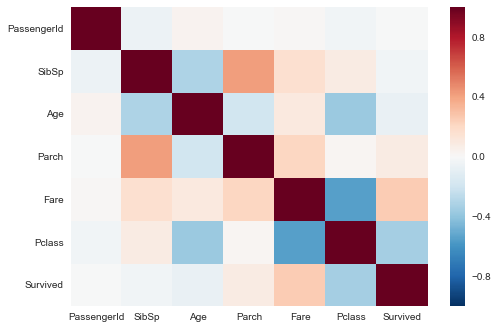

In [12]:
corrmat = train[sorted_corrs.index].corr()
sns.heatmap(corrmat)
plt.show()

In [30]:
## Pclass and Fare have a strong correlation. 
## We should only use one of them.
## Pclass and age are also pretty related
## As a result, maybe drop pclass and onlu use age and fare?
## My assumption is rich kids had a pclass of 1, but a cheap fare.